### View the current logical CPU count of the server

In [1]:
import os

NUM_CPU = len(os.sched_getaffinity(0)) #os.cpu_count() 

print(f'CPU total: {NUM_CPU}')

CPU total: 128


### Limit the number of threads that can be called by a single process

In [2]:
NUM_THREADS = 4

os.environ["MKL_NUM_THREADS"]     = str(NUM_THREADS)
os.environ["NUMEXPR_NUM_THREADS"] = str(NUM_THREADS)
os.environ["OMP_NUM_THREADS"]     = str(NUM_THREADS)

NUM_PROCESS = NUM_CPU // NUM_THREADS
print(f'Maximum number of parallel processes: {NUM_PROCESS}')

Maximum number of parallel processes: 32


### Import numpy, multiprocessing and other packages

In [2]:
pip install statsmodels

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     |████████████████████████████████| 9.9 MB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 33.5 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 4.0 MB/s  eta 0:00:01
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from numpy.random import default_rng
from time import time
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import linear_model  
import random

### Some functions needed for global calculations

In [6]:
def dup_rows(a, indx, num_dups=1):
    return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)

def dup_cols(a, indx, num_dups=1):
    return np.insert(a,[indx+1]*num_dups,a[:,[indx]],axis=1)
def function_exp(x):
    return np.exp(x)
function_vexp = np.vectorize(function_exp)
def function_bin(p,x):
    return (p**x)*(1-p)**(1-x)
function_vbin = np.vectorize(function_bin)
def function_binlog(p,x):
    return (x*np.log(p)+(1-x)*np.log(1-p))
function_vbinlog = np.vectorize(function_binlog)
def rmse(y_test, y):  
    return np.sqrt(np.mean((y_test - y) ** 2))  
def R2(y_test, y_true):  
    return 1 - ((y_test - y_true)**2).sum() / ((y_true - np.mean(y_true))**2).sum()

### EM

In [7]:
#Section 2.2-The initial estimator-EM
def em_single_initial(n,K,priors,X,Y):
    '''
    EM
    Arguments:
    priors:[pi_t,gamma_t,theta_t,sigma_t]
    Y:[n X 1 list]
    X:[n X q matrix]
    
    Returns:
    new_priors:[new_pi,new_gamma,new_theta,new_sigma]
    pi_t = priors[1:K]; gamma_t = priors[K:2*K]
    theta_t = priors[2*K:2*K+q]; sigma_t = priors[-1]
    '''
    pi_t = priors[0:K]; gamma_t = priors[K:2*K]
    theta_t = priors[2*K:2*K+q]; sigma_t = priors[-1]
    #E step -w_ik
    c = Y-np.dot(X,theta_t)
    g = np.array(gamma_t)
    g_pi = np.array(pi_t)
    a1 = (np.ones((K,n))*c.T).T
    a2 = np.ones((n,K))*g
    e_pri = -(a1-a2)**2/(2*sigma_t**2)
    e_pri = function_vexp(e_pri)
    a_pi = np.ones((n,K))*g_pi
    w_t1 = (np.divide((e_pri*a_pi).T,(np.sum(e_pri*a_pi,1)).T)).T
    

    #M step 
    new_pi = np.average(w_t1, axis=0) 
    weight = np.divide(w_t1,sum(w_t1,0))
    new_gamma = np.dot(weight.T, Y-np.dot(X, theta_t))
    V = np.dot(w_t1,gamma_t)
    trt_inv = np.dot(np.linalg.inv(np.dot(X.T,X)+np.eye(q)*0.001),X.T)
    new_theta = np.dot(trt_inv,Y-V)
    sum_sigma = 0
    w_t1_gamma_t = np.dot(w_t1,gamma_t)
    sum_sigma = {np.dot(((Y-np.dot(X,theta_t))**2).T,[1]*n)-
              2*np.dot(np.multiply(Y-np.dot(X,theta_t),w_t1_gamma_t).T,[1]*n)+
                np.dot(np.dot(w_t1,np.array(gamma_t)**2),[1]*n)}
    new_sigma = (list(sum_sigma)[0]/n)**0.5
    return list(new_pi)+list(new_gamma)+list(new_theta)+[new_sigma]

In [8]:
def initial_em(n,K,prior,X,Y,tol = 1e-3,iterations=1000):
    '''
    EM
    param Y,X :Data
    param prior：Initial
    param tol：End of Iteration Threshold
    param iterations：Maximum number of iterations
    return：Locally optimal model parameters
    '''
    iteration = 0;
    while iteration < iterations:
        new_prior = em_single_initial(n,K,prior,X,Y)
        delta_change = abs(np.array(prior)-np.array(new_prior))
        if sum(delta_change**2)**0.5<tol:
            break
        else:
            prior = new_prior
            iteration +=1
    return [new_prior,iteration]

In [9]:
def em_single_for_p(n,p,K,initial,prior_p,X,Y,Z):
    '''
    EM
    Arguments:
    initial: [pi_h,gamma_h,theta_h,sigma_h]
    priors:pj [k X 1 list]
    Y:[n X 1 list]
    X:[n X q matrix]
    Z:[n X p matrix]
    j: for p
    
    Returns:
    new_priors:new_pj
    '''
    pi_h = initial[0:K]; gamma_h = initial[K:2*K]
    theta_h = initial[2*K:2*K+q]; sigma_h = initial[-1]
    p_t = prior_p
    #E step -pi_ik
    c = Y-np.dot(X,theta_h)
    g = np.array(gamma_h)
    g_pi = np.array(pi_h)
    a1 = dup_cols(np.column_stack((c,c)), indx=0, num_dups=K-2)
    a2 = dup_rows(np.row_stack((g,g)), indx=0, num_dups=n-2)
    e_pri = -(a1-a2)**2/(2*sigma_h**2)
    e_pri = function_vexp(e_pri)
    eb_pri = np.zeros((K,n,p))
    for k in range(K):
        p_k = p_t[k,:]
        p_k_ma = np.ones((n,p))*p_k
        prod_k = p_k_ma*Z+(1-p_k_ma)*(1-Z)
        eb_pri[k,:,:] = pi_h[k]*((np.ones((p,n))*e_pri[:,k]).T)*prod_k
    pi_ik_j = np.zeros((K,n,p))
    new_p = np.zeros((K,p))
    dd = np.sum(eb_pri,0)
    for k in range(K):
        pi_ik_j[k,:,:] = np.divide(eb_pri[k,:,:],dd)
        weight_k = np.divide(pi_ik_j[k,:,:],np.sum(pi_ik_j[k,:,:],0))
        #M step
        new_p[k,:] = np.diag(np.dot(weight_k.T,Z))

    return new_p

In [32]:
def em_for_p(n,p,K,initial,prior_p,X,Y,Z,tol = 1e-2,iterations=50):
    '''
    EM
    param Y,X,Z :Data
    param prior：Initial value
    param initial: Other parameters
    param tol：End of Iteration Threshold
    param iterations：Maximum number of iterations
    return：Locally optimal model parameters
    '''
    iteration = 0;
    prior_p = (prior_p+0.001)/1.001
    while iteration < iterations:
        new_prior_p = em_single_for_p(n,p,K,initial,prior_p,X,Y,Z)
        p_change = (prior_p-new_prior_p)**2
        err_norm = np.mean((np.sum(p_change,1))**0.5)
        if err_norm<tol:
            break
        else:
            prior_p = new_prior_p
            iteration +=1
            #print(iteration, err_norm)
    return [new_prior_p,iteration]

### 1. Random split data --train and test

In [11]:
def data_split(data, seed):
    
    #train and test
    data_train, data_test = train_test_split(data, test_size = 0.5, random_state=seed)
    Y_train = np.array(data_train['penalty_prison_length'])
    X_train = np.array(data_train.loc[:,XZ_select])
    Z_train = np.array(data_train.loc[:,Z_column])
    Y_test = np.array(data_test['penalty_prison_length'])
    X_test = np.array(data_test.loc[:,XZ_select])
    Z_test = np.array(data_test.loc[:,Z_column])
    n_a = len(Y_train)
    n_e = len(Y_test)
            
    return [n_a, n_e, X_train, Y_train, Z_train, X_test, Y_test, Z_test]

### 2. Function to compute the initial value of the initial-estimator

In [12]:
def initial_pri_est(n,K,X,Y):
    
    X_s = sm.add_constant(X)
    model = sm.OLS(Y, X_s)
    model_fit = model.fit()
    model_res = model_fit.resid
    c = model_res
    clf = KMeans(n_clusters=K)
    model_res = model_res.reshape(-1,1)
    ff = clf.fit(model_res)
    classgamma = ff.cluster_centers_
    classgamma = [x[0] for x in classgamma]
    classgamma.sort()
    gamma_pri = [x+model_fit.params[0] for x in classgamma]
    theta_pri = model_fit.params[1:]
    #pi_pri
    sample_label = pd.DataFrame({'value':c, 'label_f':ff.fit_predict(model_res),
                         'center':np.zeros(n), 'label':ff.fit_predict(model_res)})
    sample_label.sort_values(by = 'label_f')
    c = []
    for k in range(K):
        idx_k = sample_label[sample_label['label_f']==k].index.tolist()
        sample_label.loc[idx_k,'center'] = np.mean(sample_label.loc[idx_k,'value'])
        c.append(np.mean(sample_label.loc[idx_k,'value']))
    c.sort()
    for k in range(K):
        idx_k = sample_label[sample_label['center']==c[k]].index.tolist()
        sample_label.loc[idx_k,'label'] = k
        sample_label.sort_values(by = 'label')
    counts = sample_label.label.value_counts()/n
    pi_pri = []
    for k in range(K):
        pi_pri.append(counts.loc[k])
    cs = [1]*K
    for k in range(K):
        idx_k = sample_label[sample_label['label']==k].index.tolist()
        cs[k] = np.std(sample_label.loc[idx_k,'value'])
    sigma_pri = np.mean(cs)
    param_pri = pi_pri+gamma_pri+list(theta_pri)+[sigma_pri]
        
    return param_pri

### 3. p_kj prior

In [13]:
def p_pri_est(n,p,K,initial_est, X, Y, Z):
    #initial estimator
    pi_ini_est = initial_est[0:K]; gamma_ini_est = initial_est[K:2*K]
    theta_ini_est = initial_est[2*K:2*K+q]; sigma_ini_est = initial_est[-1]
    
    #plj
    c = Y-np.dot(X,theta_ini_est)
    g = np.array(gamma_ini_est)
    g_pi = np.array(pi_ini_est)
    a1 = (np.ones((K,n))*c.T).T
    a2 = np.ones((n,K))*g
    e_pri = -(a1-a2)**2/(2*sigma_ini_est**2)
    e_pri = function_vexp(e_pri)
    a_pi = np.ones((n,K))*g_pi
    pi_ik_pri = (np.divide((e_pri*a_pi).T,(np.sum(e_pri*a_pi,1)).T)).T
    weight = np.divide(pi_ik_pri,sum(pi_ik_pri,0))
    p_pri = np.dot(weight.T, Z)
        
    return p_pri

### 4. Compute pi_ik

In [14]:
def pi_ik_est(n,p,K,initial_est, p_est,Z):
    #initial estimator
    pi_ini_est = initial_est[0:K]; gamma_ini_est = initial_est[K:2*K]
    theta_ini_est = initial_est[2*K:2*K+q]; sigma_ini_est = initial_est[-1]
    
    #pi_ik_est 
    g_pi = np.array(pi_ini_est)
    eb_pri = np.zeros((n,K))
    p_est[p_est<0.001] = 0.001
    p_est[p_est>0.999] = 0.999
    bigsum_nk = np.zeros((n,K))
    for k in range(K):
        bigsum_nk[:,k] = np.sum(function_vbinlog(p_est[k,:],Z), axis=1)
    bigsum_maxk = np.max(bigsum_nk, axis=1)
    for k in range(K):
        eb_pri[:,k] = function_vexp(bigsum_nk[:,k]-bigsum_maxk)
    a_pi = np.ones((n,K))*g_pi
    pi_est = (np.divide((eb_pri*a_pi).T,(np.sum(eb_pri*a_pi,1)).T)).T
        
    return pi_est

### 5. Model evaluation

In [15]:
def test_evaluation(n,p,K,initial_est, p_est,X,Y,Z):
    #posterior
    pi_est = pi_ik_est(n,p,K,initial_est, p_est, Z)
    
    X_pi = np.append(pi_est,X,axis=1)
    trt_inv_pi = np.dot(np.linalg.inv(np.dot(X_pi.T,X_pi)+np.eye(K+q)*0.001),X_pi.T)
    Phi_real = np.dot(trt_inv_pi,Y)
    
    Y_pred = np.dot(X_pi, Phi_real)
    RMSE = np.sqrt(np.mean((Y_pred - Y)**2))  
    
    test_R2 = 1 - ((Y_pred - Y)**2).sum() / ((Y - np.mean(Y))**2).sum()
    print(test_R2)
    
    return [RMSE, test_R2]

### 6.a Define a mapping: random number seed $\mapsto$ estimator

In [31]:
def map_fun(b):
   
    n_a, n_e, X_train, Y_train, Z_train, X_test, Y_test, Z_test = data_split(demo_data, seed = b) #data
    
    initial_pri = initial_pri_est(n_a, K, X_train, Y_train)                       #initial prior
    initial_est, initial_iter = initial_em(n_a,K, initial_pri, X_train, Y_train)  #initial est
    
    p_pri = p_pri_est(n_a,p,K,initial_est, X_train, Y_train, Z_train)             #pkj prior
    p_est, p_iter = em_for_p(n_a,p,K,initial_est,p_pri,X_train, Y_train, Z_train) #pkj est
    #print(p_iter)
    
    RMSE, test_R2 = test_evaluation(n_e,p,K,initial_est, p_est, X_test, Y_test,Z_test) #test R2
    print('b:', b, 'p_iter: ', p_iter, 'testR2: ', test_R2)
    with open('MCR_progress.txt','a') as f:
        f.write(str(b)+', '+str(test_R2)+'\n')
    
    return [RMSE, test_R2] 

### 6.b Define a mapping: random number seed $\mapsto$ estimator ---ols

In [24]:
def map_fun_ols(b):
    #print(b)
    n_a, n_e, X_train, Y_train, Z_train, X_test, Y_test, Z_test = data_split(demo_data, seed = b) # data
    
    Y_s = Y_train
    X_s = sm.add_constant(X_train)
    
    trt_inv = np.dot(np.linalg.inv(np.dot(X_s.T,X_s)+np.eye(q+1)*0.001),X_s.T)
    new_theta = np.dot(trt_inv,Y_train) 
    
    test_x = sm.add_constant(X_test)
    y_pred = np.dot(test_x,new_theta) 
    
    RMSE = rmse(y_pred, Y_test)
    test_R2  = R2(y_pred, Y_test)
    print('testR2: ', test_R2)
    
    return [RMSE, test_R2] 

### 7. Data

In [19]:
demo_data = pd.read_csv('data_room_mo.csv')
XZ_select = (pd.read_csv('XZ_select.csv')).iloc[:,0].tolist()
colum = demo_data.columns.tolist()
colum.remove('id')
colum.remove('penalty_prison_length')
Z_column = list(set(colum).difference(set(XZ_select)))

p = len(Z_column); q = len(XZ_select); B = 1000; K = 7; n = len(demo_data)

### 8. Calling multiple processes for simulation experiments

In [ ]:
tic1 = time()

with mp.Pool(NUM_PROCESS) as pool: 
    Results1 = pool.map(map_fun, range(B))

toc1 = time()
print(toc1 - tic1) # total time

1 0.40454511984977065
1 0.36252976452590074
1 0.41521093464927883
1 0.5489247347359969
1 0.4820529810855236
1 0.41638058546408463
1 0.4644398031816766
1 0.5391779040390098
2 0.14100772234307554
2 0.12593136375010092
2 0.2505388252775822
2 0.15177475935054358
2 0.19468914259234485
2 0.17943257255720774
2 0.12923045888281798
2 0.21398481718578038
3 0.0766490217110304
3 0.07202491997140827
3 0.12414706486696833
3 0.08234250905459246
3 0.057943544505972944
3 0.10029738237430708
3 0.0878531973931849
3 0.10508544241334347
4 0.05581816738120922
4 0.05535382604548794
4 0.06997576078103203
4 0.0371371920174556
4 0.0560230743983479
4 0.05697327563284708
4 0.06708057645354368
4 0.06379328599468605
5 0.04411658651970645
5 0.04619344653087011
5 0.0456623535250471
5 0.029618277650485504
5 0.04369363051217686
5 0.05352149970618398
5 0.044022068085403106
5 0.04436398610826949
6 0.03585900629439801
6 0.03968697891065438
6 0.025989633553938324
6 0.037486492128169256
6 0.03389010055854377
6 0.04682202721

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



testR2:  0.4741605894117691
30 0.01916655383762044
31 0.018750927471609943
1 0.38818003666837697
1 0.566833986886918
1 0.4216819763153505
32 0.018347930570130126
2 0.13299443502893613
2 0.2340035640472896
0.45203602806711707
b: 94 p_iter:  31 testR2:  0.45203602806711707
2 0.13649351319989186
33 0.017957128229474657
3 0.056503140888214
3 0.11908763986346009
3 0.07036169595636425
34 0.01757811309596739
1 0.4520918813442049
4 0.02917350452630883
4 0.0742259245095654
4 0.05005804900550785
35 0.017210495957620666
2 0.1583174820138175
5 0.017461483742919306
5 0.05375921884029089
5 0.040636840037026487
36 0.016853900820125774
3 0.07946118464021212
6 0.01157046379743227
6 0.0429830233617834
6 0.03474782727227029
37 0.016507962528444754
4 0.052630187095114966
7 0.030627049863295047
7 0.036437467825290414
38 0.016172325771847396
5 0.04044127520859008
8 0.027774896266828473
8 0.03199654428055175
39 0.015846644794534553
6 0.03359776395041114
9 0.025787180094848428
9 0.028745860125676374
40 0.0155

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0.010662630530282638
2 0.1464977171097486
14 0.028161227506085008
0.4768161983663566
b: 291 p_iter:  9 testR2:  0.4768161983663566
8 0.025521706376879172
42 0.010492728745875942
15 0.02727379024678739
3 0.07375312805123138
9 0.02412858996412734
43 0.010326401507359124
1 0.377219575028828
16 0.026440430945581885
4 0.05046070351253167
10 0.02303578905492366
0.48271445726717943
b: 387 p_iter:  50 testR2:  0.48271445726717943
44 0.010163568471682035
2 0.10964488038398139
11 0.02212144672785687
5 0.03883825427409231
17 0.025652095079043813
45 0.010004148343842747
1 0.5136879153929089
3 0.04655705720909043
12 0.021328712356161742
18 0.024903102430814415
6 0.031465106243080146
2 0.1947461354809843
4 0.026482961247951402
13 0.0206292395472541
19 0.024189624845948533
7 0.026528137396972646
3 0.0948983337224616
5 0.018131839236294137
14 0.020003984991884074
20 0.023508802039261617
8 0.023062208901565018
4 0.06087962729691043
6 0.013874876593235191
15 0.019439045564933737
21 0.022858266232383923

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




37 0.01172636671704846
2 0.09682404599358181
1 0.46181546794345635
12 0.026743514963650742
12 0.022382745315683347
1 0.413919694007464
2 0.14768998002926217
3 0.049739887867631706
38 0.011553906656589811
13 0.025368885616631812
2 0.14029244078568714
4 0.03697150766805438
3 0.06698743458807814
13 0.02057561494658015
39 0.011384633400128638
14 0.024160249373285713
40 0.011218425229478666
5 0.031182480635944306
3 0.07188063713924452
4 0.04318380366320775
14 0.018978354306336896
15 0.02308008932312337
41 0.011055188533072606
5 40.03417837174531098 
0.05032940174172241
6 0.02745642278745813
15 0.017551749420459464
16 0.022101966476587798
42 0.010894849164099564
5 0.040944778784460865
7 0.024506822625942132
6 0.02972698744107414
16 0.016265965872890448
17 0.0212069805470261
43 0.010737346182582671
6 0.03545146434443545
8 0.022039029125324412
17 0.015098731935669575
7 0.026926695730440868
18 0.02038181683002032
44 0.010582627367949595
9 0.01995036955615142
7 0.03133723774372364
18 0.01403364

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



p_iter:  50 testR2:  0.4584097161547096
5 0.016877747462706007
27 0.01657660990696797
36 0.010981799557480321
10 0.016283010330913724
15 0.01238357114787543
6 0.012700889921642393
28 0.016004514209990203
1 0.46868424472896075
37 0.01065405329046607
11 0.013974593941839804
16 0.01204436911256557
29 0.015468045731557176
38 0.010340533948342683
2 0.1847997549987201
12 0.012089754749973163
17 0.011750707142788919
30 0.014965341004137805
39 0.010040429818006093
3 0.09371311895996277
13 0.010528557846737367
18 0.011493823858256407
31 0.014495778805139251
4 0.06146208560824246
19 0.011266279198200202
32 0.014060186193369727
0.4734777863891082
b: 366 p_iter:  6 testR2:  0.4734777863891082
5 0.047677702416046554
20 0.01106188011419601
33 0.013660873518895675
6 0.04016059148372385
1 0.5436300304431301
21 0.010875611440518754
34 0.013300876384535825
7 0.03534653847332622
2 0.21087436847862925
22 0.010703522746526596
35 0.012981679073099009
8 0.032034968466680976
23 0.010542576441914298
3 0.106436

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2 0.25704097224241246
11 0.014200526639191463
15 0.015165842008860028
47 0.010769444796062714
3 0.13170871302886433
12 0.013904831920649405
48 0.010638645812529381
16 0.014345209849305306
4 0.08081691951436223
13 0.013662848830436702
49 0.010513020778951679
17 0.013619877472209956
5 0.057241505752211715
14 0.013450292560339043
50 0.01039199389960794
18 0.01297063731076929
6 0.04487881056599498
15 0.013255309103783705
19 0.012382522479719268
16 0.013072249990783795
7 0.03743940033664174
20 0.011844580456465621
17 0.01289839664012836
8 0.03219743991441714
21 0.011348975953218984
18 0.012732326933784314
9 0.02814078323638707
22 0.010890018149136125
19 0.012573142721692382
10 0.024892617393642635
23 0.010463392174573472
20 0.012420124173478821
11 0.02226692077695795
24 0.010065645834152408
21 0.012272590907326741
12 0.02013836215523183
22 0.012129863493134113
13 0.018393605632977535
23 0.011991272296827647
14 0.016932990725822484
0.4626885918411009
b: 403 p_iter:  26 testR2:  0.46268859184

### 9. Obtain results

In [ ]:
RMSE_mcr_B1000 = np.zeros(B)
test_R2_mcr_B1000 = np.zeros(B)
for b in range(B):
    RMSE_mcr_B1000[b] = Results1[b][0]
    test_R2_mcr_B1000[b] = Results1[b][1]
pd.DataFrame({'RMSE':RMSE_mcr_B1000,'testR2':test_R2_mcr_B1000}).to_csv("mcr_K7_B1000.csv",index=False)

In [ ]:
RMSE_ols_B1000 = np.zeros(B)
test_R2_ols_B1000 = np.zeros(B)
for b in range(B):
    RMSE_ols_B1000[b] = Results1[b][0]
    test_R2_ols_B1000[b] = Results1[b][1]

pd.DataFrame({'RMSE':RMSE_ols_B1000,'testR2':test_R2_ols_B1000}).to_csv("ols_B1000.csv",index=False)

In [ ]:
# Save results
test_R2_mcr_B1000 = pd.read_csv("mcr_K7_B1000.csv")
test_R2_ols_B1000 = pd.read_csv("ols_B1000.csv")

### 10. Two sample test

In [6]:
test_R2_mcr_B1000 = (pd.read_csv('mcr_K7_B1000.csv')).loc[:,'testR2']
test_R2_ols_B1000 = (pd.read_csv('ols_B1000.csv')).loc[:,'testR2']

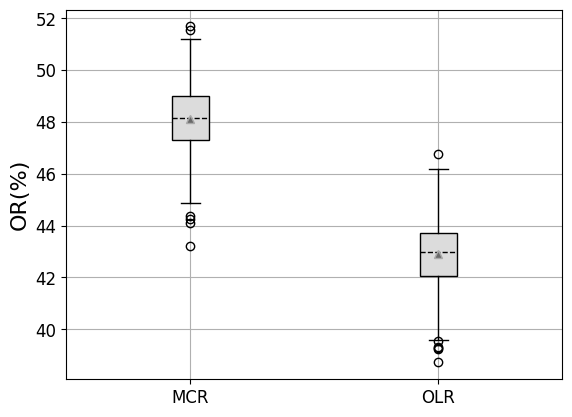

In [7]:
# Plot
ddp = np.array([test_R2_K7B1000.tolist(),test_R2_ols_B1000.tolist()])*100
dfp = pd.DataFrame(ddp.T,columns=['MCR','OLR'])
plt.ylabel('OR(%)',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fg = dfp.boxplot(sym = 'o',            
               vert = True,         
               patch_artist = True,  
               meanline = False,showmeans = True, 
               showbox = True,  
               boxprops = {'facecolor':'gainsboro'},
               whiskerprops = {'color':'black'},
               medianprops = {'linestyle':'--','color':'black'},
               meanprops = {'markeredgecolor':'darkgrey','markerfacecolor':'dimgrey'},
               showfliers = True,  
               notch = False,   
               return_type='dict') 

plt.grid(True) 
plt.savefig("../Results/0305OR.pdf")
plt.show()

In [10]:
mcr = np.array(test_R2_mcr_B1000)
ols = np.array(test_R2_ols_B1000)

In [11]:
import scipy.stats as stats

#perform two sample t-test with equal variances
stats.ttest_ind(a=mcr, b=ols, equal_var=True)

TtestResult(statistic=95.12117967870057, pvalue=0.0, df=1998.0)

In [12]:
# Kruskal-Wallis rank test
stats.kruskal(mcr,ols)

KruskalResult(statistic=1490.1786820089947, pvalue=0.0)

In [13]:
# Mann-Whitney U test
stats.mannwhitneyu(mcr, ols)

MannwhitneyuResult(statistic=998485.0, pvalue=0.0)